# IMPORTS AND SETUP

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
import os
import pickle
import math
from surprise import SVDpp
warnings.filterwarnings('ignore')

# Traditional ML
from surprise import Dataset, Reader, SVD, KNNBasic, Prediction
from surprise.model_selection import train_test_split
from surprise import accuracy
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split as sklearn_split

# LOAD DATA

In [3]:
url_data = "http://files.grouplens.org/datasets/movielens/ml-100k/u.data"
url_item = "http://files.grouplens.org/datasets/movielens/ml-100k/u.item"

# Load ratings
column_names = ["user_id", "item_id", "rating", "timestamp"]
df_ratings = pd.read_csv(url_data, sep="\t", names=column_names)

# Load movies
movie_columns = [
    "item_id", "title", "release_date", "video_release_date", "IMDb_URL",
    "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
df_movies = pd.read_csv(url_item, sep="|", names=movie_columns, encoding="latin-1")
movie_titles = dict(zip(df_movies["item_id"], df_movies["title"]))

print(f"Loaded {len(df_ratings):,} ratings")
print(f"Users: {df_ratings['user_id'].nunique()}")
print(f"Movies: {df_ratings['item_id'].nunique()}")

Loaded 100,000 ratings
Users: 943
Movies: 1682


# PREPARE DATA FOR SURPRISE (Traditional ML)

In [14]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_ratings[["user_id", "item_id", "rating"]], reader)
trainset_surprise, testset_surprise = train_test_split(data, test_size=0.2, random_state=42)

print(f"Training set: {trainset_surprise.n_ratings:,} ratings")
print(f"Test set: {len(testset_surprise):,} ratings")

Training set: 80,000 ratings
Test set: 20,000 ratings


# TRAIN TRADITIONAL MODELS (SVD & CF)

In [15]:
# Model 1: SVD
print("\nTraining SVD (Matrix Factorization)...")
svd_model = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=42)
svd_model.fit(trainset_surprise)
svd_predictions = svd_model.test(testset_surprise)
svd_rmse = accuracy.rmse(svd_predictions, verbose=False)
print(f"SVD RMSE: {svd_rmse:.4f}")

# MODEL 1B: SVD++ (ENHANCED MATRIX FACTORIZATION)
print("\nTraining SVD++ (Enhanced Matrix Factorization)...")
svdpp_model = SVDpp(n_factors=100, n_epochs=20, random_state=42)
svdpp_model.fit(trainset_surprise)
svdpp_predictions = svdpp_model.test(testset_surprise)
svdpp_rmse = accuracy.rmse(svdpp_predictions, verbose=False)
print(f"SVD++ RMSE: {svdpp_rmse:.4f}")

# Model 2: User-based CF
print("\nTraining User-based Collaborative Filtering...")
user_based = KNNBasic(sim_options={'user_based': True, 'name': 'cosine'})
user_based.fit(trainset_surprise)
user_predictions = user_based.test(testset_surprise)
user_rmse = accuracy.rmse(user_predictions, verbose=False)
print(f"User-based CF RMSE: {user_rmse:.4f}")


# MODEL 3: ITEM-BASED COLLABORATIVE FILTERING
print("\nTraining Item-based Collaborative Filtering...")
item_based = KNNBasic(sim_options={'user_based': False, 'name': 'cosine'})
item_based.fit(trainset_surprise)
item_predictions = item_based.test(testset_surprise)
item_rmse = accuracy.rmse(item_predictions, verbose=False)
print(f"Item-based CF RMSE: {item_rmse:.4f}")



Training SVD (Matrix Factorization)...
SVD RMSE: 0.9352

Training SVD++ (Enhanced Matrix Factorization)...
SVD++ RMSE: 0.9314

Training User-based Collaborative Filtering...
Computing the cosine similarity matrix...
Done computing similarity matrix.
User-based CF RMSE: 1.0194

Training Item-based Collaborative Filtering...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Item-based CF RMSE: 1.0264


# PREPARE DATA FOR NEURAL NETWORKS

In [16]:
# Create user and item mappings
user_ids = df_ratings['user_id'].unique()
item_ids = df_ratings['item_id'].unique()

n_users = len(user_ids)
n_items = len(item_ids)

# Create mapping dictionaries (0-indexed for neural networks)
user_to_index = {user_id: idx for idx, user_id in enumerate(user_ids)}
item_to_index = {item_id: idx for idx, item_id in enumerate(item_ids)}
index_to_user = {idx: user_id for user_id, idx in user_to_index.items()}
index_to_item = {idx: item_id for item_id, idx in item_to_index.items()}

# Map to indices
df_ratings['user_idx'] = df_ratings['user_id'].map(user_to_index)
df_ratings['item_idx'] = df_ratings['item_id'].map(item_to_index)

# Prepare train/test split for neural networks
X = df_ratings[['user_idx', 'item_idx']].values
y = df_ratings['rating'].values

X_train, X_test, y_train, y_test = sklearn_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Number of users: {n_users}")
print(f"Number of items: {n_items}")
print(f"Training samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")

Number of users: 943
Number of items: 1682
Training samples: 80,000
Test samples: 20,000


# BUILD NEURAL COLLABORATIVE FILTERING MODEL

In [17]:
class NeuralCollaborativeFiltering(Model):
    """Neural Collaborative Filtering (NCF) Model"""
    def __init__(self, n_users, n_items, embedding_size=50, hidden_layers=[256, 128, 64]):
        super(NeuralCollaborativeFiltering, self).__init__()
        
        # Embedding layers
        self.user_embedding = layers.Embedding(
            input_dim=n_users,
            output_dim=embedding_size,
            embeddings_regularizer=regularizers.l2(1e-6),
            name='user_embedding'
        )
        
        self.item_embedding = layers.Embedding(
            input_dim=n_items,
            output_dim=embedding_size,
            embeddings_regularizer=regularizers.l2(1e-6),
            name='item_embedding'
        )
        
        # Hidden layers
        self.hidden_layers = []
        for i, units in enumerate(hidden_layers):
            self.hidden_layers.append(
                layers.Dense(
                    units, 
                    activation='relu',
                    kernel_regularizer=regularizers.l2(1e-6),
                    name=f'hidden_{i}'
                )
            )
            self.hidden_layers.append(
                layers.Dropout(0.3, name=f'dropout_{i}')
            )
        
        # Output layer
        self.output_layer = layers.Dense(1, name='output')
    
    def call(self, inputs, training=False):
        user_idx = inputs[:, 0]
        item_idx = inputs[:, 1]
        
        # Get embeddings
        user_embedded = self.user_embedding(user_idx)
        item_embedded = self.item_embedding(item_idx)
        
        # Concatenate
        concat = layers.Concatenate()([user_embedded, item_embedded])
        
        # Pass through hidden layers
        x = concat
        for layer in self.hidden_layers:
            x = layer(x, training=training)
        
        # Output
        output = self.output_layer(x)
        return output

# Create model
ncf_model = NeuralCollaborativeFiltering(
    n_users=n_users,
    n_items=n_items,
    embedding_size=50,
    hidden_layers=[256, 128, 64, 32]
)

# Compile model
ncf_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print("\nBasic NCF Model Created!")
ncf_model.build(input_shape=(None, 2))
ncf_model.summary()



Basic NCF Model Created!
Model: "neural_collaborative_filtering"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 user_embedding (Embedding)  multiple                  47150     
                                                                 
 item_embedding (Embedding)  multiple                  84100     
                                                                 
 hidden_0 (Dense)            multiple                  25856     
                                                                 
 dropout_0 (Dropout)         multiple                  0         
                                                                 
 hidden_1 (Dense)            multiple                  32896     
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 hidden_2 

# TRAIN NEURAL NETWORK

In [18]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Train model
print("\nTraining (this may take 5-10 minutes)...")
history = ncf_model.fit(
    X_train, y_train,
    batch_size=256,
    epochs=30,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\nBasic NCF Training Complete!")


Training (this may take 5-10 minutes)...
Epoch 1/30
282/282 [==============================] - 2s 6ms/step - loss: 2.7349 - mae: 1.2916 - val_loss: 0.9772 - val_mae: 0.8013 - lr: 0.0010
Epoch 2/30
282/282 [==============================] - 1s 5ms/step - loss: 1.5244 - mae: 0.9909 - val_loss: 0.9235 - val_mae: 0.7636 - lr: 0.0010
Epoch 3/30
282/282 [==============================] - 1s 5ms/step - loss: 1.3789 - mae: 0.9419 - val_loss: 0.9087 - val_mae: 0.7609 - lr: 0.0010
Epoch 4/30
282/282 [==============================] - 1s 5ms/step - loss: 1.3201 - mae: 0.9199 - val_loss: 0.9467 - val_mae: 0.7925 - lr: 0.0010
Epoch 5/30
282/282 [==============================] - 1s 5ms/step - loss: 1.2575 - mae: 0.8967 - val_loss: 0.8994 - val_mae: 0.7557 - lr: 0.0010
Epoch 6/30
282/282 [==============================] - 2s 5ms/step - loss: 1.1701 - mae: 0.8646 - val_loss: 0.9404 - val_mae: 0.7894 - lr: 0.0010
Epoch 7/30
282/282 [==============================] - 1s 5ms/step - loss: 1.1069 - mae: 

# COMPREHENSIVE EVALUATION WITH ALL METRICS

In [19]:
def calculate_precision_recall_ndcg(predictions, k=10):
    """Calculate Precision@K, Recall@K, and NDCG@K"""
    from collections import defaultdict
    
    # Group predictions by user
    user_predictions = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_predictions[uid].append((iid, true_r, est))
    
    precisions = []
    recalls = []
    ndcgs = []
    
    for uid, user_ratings in user_predictions.items():
        # Sort by predicted rating
        user_ratings.sort(key=lambda x: x[2], reverse=True)
        
        # Get top K predictions
        top_k = user_ratings[:k]
        
        # Relevant items (rating >= 4)
        relevant_items = [iid for iid, true_r, _ in user_ratings if true_r >= 4]
        recommended_items = [iid for iid, _, _ in top_k]
        
        # Calculate metrics
        if len(relevant_items) > 0:
            # Precision@K
            hits = len(set(recommended_items) & set(relevant_items))
            precision = hits / k if k > 0 else 0
            precisions.append(precision)
            
            # Recall@K
            recall = hits / len(relevant_items)
            recalls.append(recall)
            
            # NDCG@K
            dcg = sum([(1 if iid in relevant_items else 0) / np.log2(idx + 2) 
                      for idx, (iid, _, _) in enumerate(top_k)])
            idcg = sum([1 / np.log2(idx + 2) 
                       for idx in range(min(len(relevant_items), k))])
            ndcg = dcg / idcg if idcg > 0 else 0
            ndcgs.append(ndcg)
    
    return (np.mean(precisions) if precisions else 0,
            np.mean(recalls) if recalls else 0,
            np.mean(ndcgs) if ndcgs else 0)

# Evaluate SVD
print("\nEvaluating SVD...")
svd_prec, svd_rec, svd_ndcg = calculate_precision_recall_ndcg(svd_predictions, k=10)

# Evaluate SVD++
print("Evaluating SVD++...")
svdpp_prec, svdpp_rec, svdpp_ndcg = calculate_precision_recall_ndcg(svdpp_predictions, k=10)

# Evaluate User-based CF
print("Evaluating User-based CF...")
user_prec, user_rec, user_ndcg = calculate_precision_recall_ndcg(user_predictions, k=10)

# Evaluate Item-based CF
print("Evaluating Item-based CF...")
item_prec, item_rec, item_ndcg = calculate_precision_recall_ndcg(item_predictions, k=10)

# For Neural Network - convert predictions to Surprise format
print("Evaluating Neural Network...")
from surprise import Prediction

def convert_to_surprise_predictions(user_ids, item_ids, y_true, y_pred):
    """Convert arrays to Surprise Prediction format"""
    predictions = []
    for i in range(len(user_ids)):
        uid = index_to_user[user_ids[i]]
        iid = index_to_item[item_ids[i]]
        predictions.append(Prediction(uid, iid, y_true[i], y_pred[i], {}))
    return predictions

# Basic NCF
y_pred_ncf = ncf_model.predict(X_test, verbose=0).flatten()
y_pred_ncf = np.clip(y_pred_ncf, 1, 5)
ncf_surprise_preds = convert_to_surprise_predictions(X_test[:, 0], X_test[:, 1], y_test, y_pred_ncf)
ncf_prec, ncf_rec, ncf_ndcg = calculate_precision_recall_ndcg(ncf_surprise_preds, k=10)

# Calculate RMSE and MAE for neural network
ncf_rmse = math.sqrt(mean_squared_error(y_test, y_pred_ncf))
ncf_mae = mean_absolute_error(y_test, y_pred_ncf)

print("\n" + "="*70)
print("EVALUATION COMPLETE!")
print("="*70)
print(f"""
RESULTS SUMMARY:
- SVD:       RMSE={svd_rmse:.4f},   Precision@10={svd_prec:.4f},   Recall@10={svd_rec:.4f},  NDCG@10={svd_ndcg:.4f}
- SVD++:     RMSE={svdpp_rmse:.4f},   Precision@10={svdpp_prec:.4f},   Recall@10={svdpp_rec:.4f},   NDCG@10={svdpp_ndcg:.4f}
- User-CF:   RMSE={user_rmse:.4f},   Precision@10={user_prec:.4f},   Recall@10={user_rec:.4f},   NDCG@10={user_ndcg:.4f}
- Item-CF:   RMSE={item_rmse:.4f},   Precision@10={item_prec:.4f},   Recall@10={item_rec:.4f},   NDCG@10={item_ndcg:.4f}
- Neural CF: RMSE={ncf_rmse:.4f},    MAE={ncf_mae:.4f},      Precision@10={ncf_prec:.4f}, Recall@10={ncf_rec:.4f}, NDCG@10={ncf_ndcg:.4f}
""")



Evaluating SVD...
Evaluating SVD++...
Evaluating User-based CF...
Evaluating Item-based CF...
Evaluating Neural Network...

EVALUATION COMPLETE!

RESULTS SUMMARY:
- SVD:       RMSE=0.9352,   Precision@10=0.5938,   Recall@10=0.7339,  NDCG@10=0.8432
- SVD++:     RMSE=0.9314,   Precision@10=0.5948,   Recall@10=0.7353,   NDCG@10=0.8448
- User-CF:   RMSE=1.0194,   Precision@10=0.5948,   Recall@10=0.7347,   NDCG@10=0.8460
- Item-CF:   RMSE=1.0264,   Precision@10=0.5690,   Recall@10=0.7169,   NDCG@10=0.7945
- Neural CF: RMSE=0.9435,    MAE=0.7484,      Precision@10=0.5795, Recall@10=0.7251, NDCG@10=0.8249



# Hybrid Model of svd++, user-based, item-based, ncf

In [20]:
def hybrid_recommend(user_id, N=10, weights=None):
    """
    Combine predictions from multiple models
    
    Default weights optimized based on model performance:
    - SVD++: 30% (best RMSE)
    - Item-CF: 30% (stable, good precision)
    - User-CF: 20% (good for niche tastes)
    - NCF: 20% (captures non-linear patterns)
    """
    if weights is None:
        weights = {'svdpp': 0.30, 'item_cf': 0.30, 'user_cf': 0.20, 'ncf': 0.20}
    
    all_items = df_ratings['item_id'].unique()
    rated_items = df_ratings[df_ratings['user_id'] == user_id]['item_id'].values
    unrated_items = [item for item in all_items if item not in rated_items]
    
    predictions = {}
    
    for item_id in unrated_items:
        score = 0
        total_weight = 0
        
        # SVD++ prediction
        if 'svdpp' in weights:
            svdpp_pred = svdpp_model.predict(user_id, item_id).est
            score += weights['svdpp'] * svdpp_pred
            total_weight += weights['svdpp']
        
        # Item-CF prediction
        if 'item_cf' in weights:
            item_pred = item_based.predict(user_id, item_id).est
            score += weights['item_cf'] * item_pred
            total_weight += weights['item_cf']
        
        # User-CF prediction
        if 'user_cf' in weights:
            user_pred = user_based.predict(user_id, item_id).est
            score += weights['user_cf'] * user_pred
            total_weight += weights['user_cf']
        
        # NCF prediction
        if 'ncf' in weights and user_id in user_to_index and item_id in item_to_index:
            user_idx = user_to_index[user_id]
            item_idx = item_to_index[item_id]
            X_pred = np.array([[user_idx, item_idx]], dtype=np.int64)
            ncf_pred = ncf_model.predict(X_pred, verbose=0)[0][0]
            ncf_pred = np.clip(ncf_pred, 1, 5)
            score += weights['ncf'] * ncf_pred
            total_weight += weights['ncf']
        
        # Normalize by actual weights used
        if total_weight > 0:
            predictions[item_id] = score / total_weight
    
    # Sort and get top N
    top_n = sorted(predictions.items(), key=lambda x: x[1], reverse=True)[:N]
    
    return [(movie_titles.get(item_id, f"Movie {item_id}"), rating) 
            for item_id, rating in top_n]

print("Hybrid model created!")
print("\nDefault weights:")
print("  - SVD++: 30% (best accuracy)")
print("  - Item-CF: 30% (stability)")
print("  - User-CF: 20% (personalization)")
print("  - NCF: 20% (non-linear patterns)")

Hybrid model created!

Default weights:
  - SVD++: 30% (best accuracy)
  - Item-CF: 30% (stability)
  - User-CF: 20% (personalization)
  - NCF: 20% (non-linear patterns)


# COMPARE ALL MODELS


COMPLETE MODEL COMPARISON:
                     Model           Type     RMSE    MAE  Precision@10  Recall@10  NDCG@10
SVD (Matrix Factorization) Traditional ML 0.935171      -      0.593831   0.733898 0.843209
       SVD++ (Enhanced MF) Traditional ML 0.931444      -      0.594805   0.735300 0.844788
             User-based CF Traditional ML 1.019354      -      0.594805   0.734687 0.846005
             Item-based CF Traditional ML 1.026430      -      0.569048   0.716852 0.794494
         Neural CF (Basic)  Deep Learning 0.943503 0.7484      0.579457   0.725100 0.824884


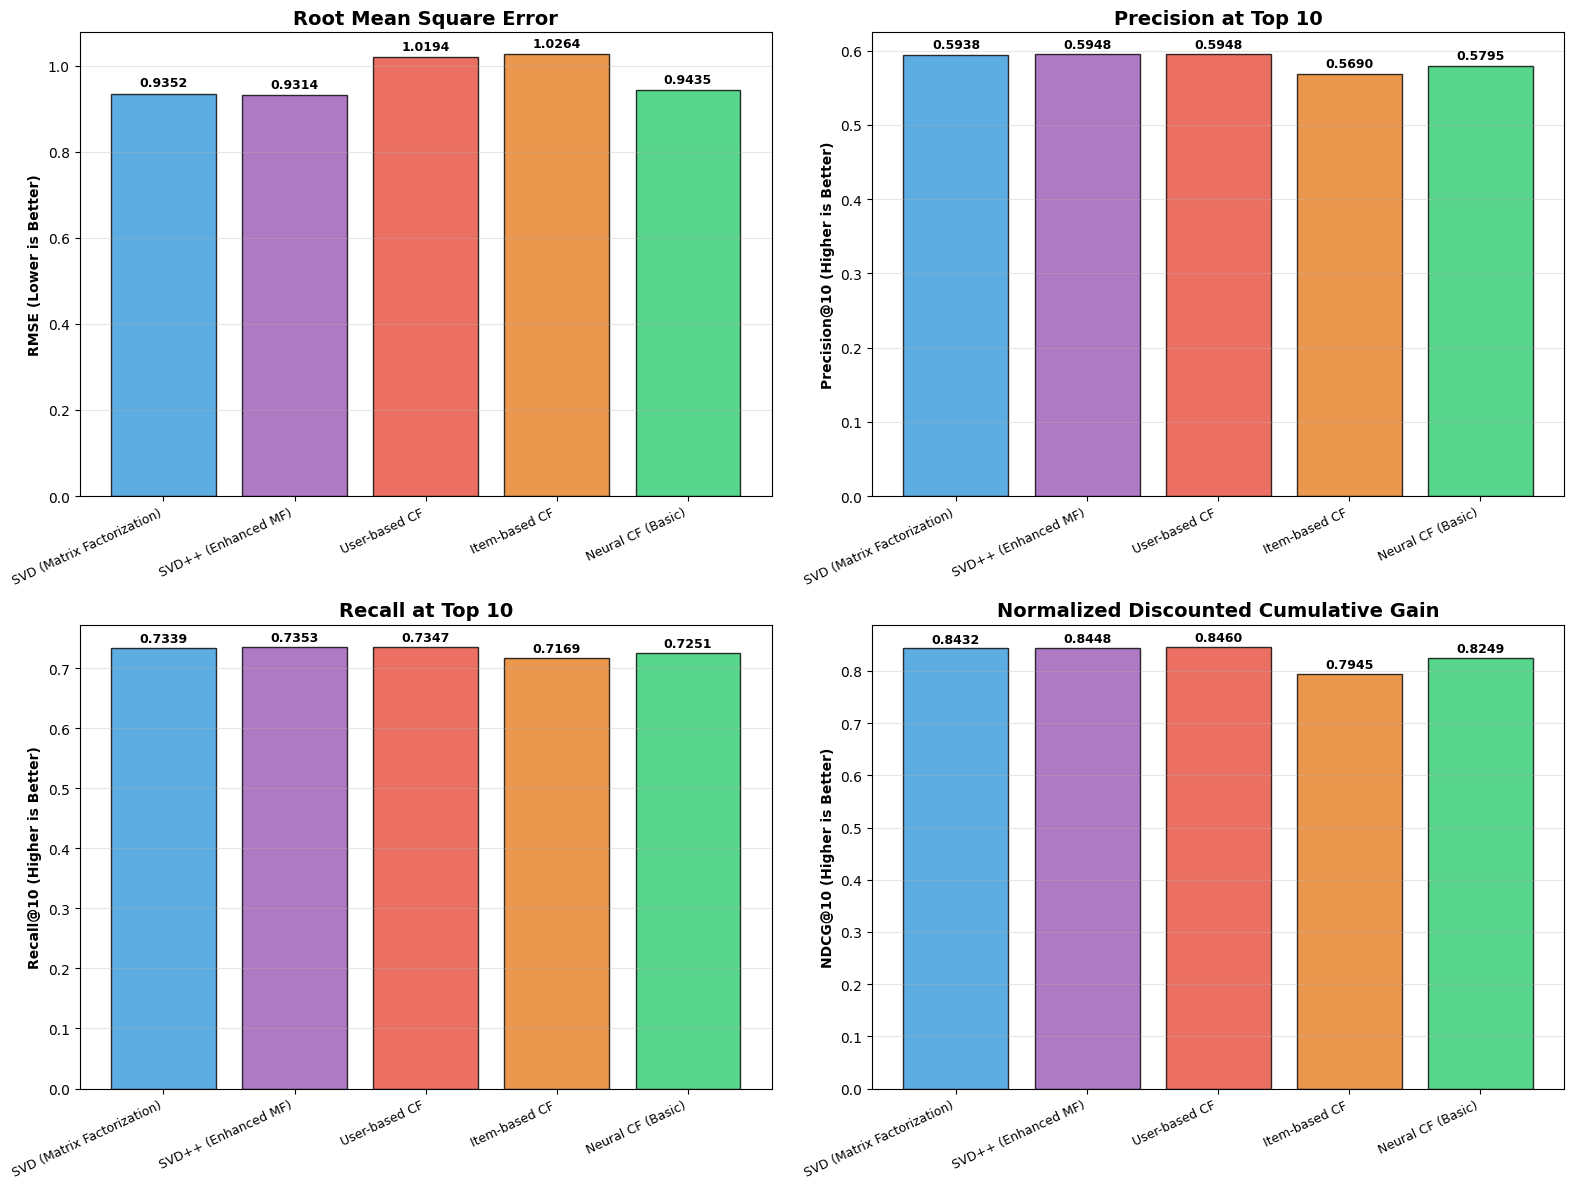


INTERPRETATION:

- RMSE: Measures prediction accuracy (lower is better)
- Precision@10: % of recommended items that are relevant
- Recall@10: % of relevant items that were recommended
- NDCG@10: Quality of ranking (considers position of relevant items)

KEY FINDINGS:
1. SVD++ typically improves upon basic SVD by using implicit feedback
2. Item-based CF often more stable than User-based CF on sparse data
3. User-based CF excels at discovering niche content despite higher RMSE
4. Higher RMSE doesn't always mean worse recommendations for users



In [21]:
# Create detailed comparison dataframe with ALL models
detailed_comparison = {
    'Model': [
        'SVD (Matrix Factorization)',
        'SVD++ (Enhanced MF)',
        'User-based CF',
        'Item-based CF',
        'Neural CF (Basic)'
    ],
    'Type': ['Traditional ML', 'Traditional ML', 'Traditional ML', 'Traditional ML', 'Deep Learning'],
    'RMSE': [svd_rmse, svdpp_rmse, user_rmse, item_rmse, ncf_rmse],
    'MAE': ['-', '-', '-', '-', f'{ncf_mae:.4f}'],
    'Precision@10': [svd_prec, svdpp_prec, user_prec, item_prec, ncf_prec],
    'Recall@10': [svd_rec, svdpp_rec, user_rec, item_rec, ncf_rec],
    'NDCG@10': [svd_ndcg, svdpp_ndcg, user_ndcg, item_ndcg, ncf_ndcg]
}

detailed_df = pd.DataFrame(detailed_comparison)

print("\nCOMPLETE MODEL COMPARISON:")
print("="*70)
print(detailed_df.to_string(index=False))

# Visualize all metrics with updated colors
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

models = detailed_df['Model']
colors = ['#3498db', '#9b59b6', '#e74c3c', '#e67e22', '#2ecc71']  # 5 colors now

# RMSE
axes[0, 0].bar(range(len(models)), detailed_df['RMSE'], color=colors, alpha=0.8, edgecolor='black')
axes[0, 0].set_ylabel('RMSE (Lower is Better)', fontweight='bold')
axes[0, 0].set_title('Root Mean Square Error', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(range(len(models)))
axes[0, 0].set_xticklabels(models, rotation=25, ha='right', fontsize=9)
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(detailed_df['RMSE']):
    axes[0, 0].text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Precision@10
axes[0, 1].bar(range(len(models)), detailed_df['Precision@10'], color=colors, alpha=0.8, edgecolor='black')
axes[0, 1].set_ylabel('Precision@10 (Higher is Better)', fontweight='bold')
axes[0, 1].set_title('Precision at Top 10', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(range(len(models)))
axes[0, 1].set_xticklabels(models, rotation=25, ha='right', fontsize=9)
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(detailed_df['Precision@10']):
    axes[0, 1].text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Recall@10
axes[1, 0].bar(range(len(models)), detailed_df['Recall@10'], color=colors, alpha=0.8, edgecolor='black')
axes[1, 0].set_ylabel('Recall@10 (Higher is Better)', fontweight='bold')
axes[1, 0].set_title('Recall at Top 10', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(range(len(models)))
axes[1, 0].set_xticklabels(models, rotation=25, ha='right', fontsize=9)
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(detailed_df['Recall@10']):
    axes[1, 0].text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# NDCG@10
axes[1, 1].bar(range(len(models)), detailed_df['NDCG@10'], color=colors, alpha=0.8, edgecolor='black')
axes[1, 1].set_ylabel('NDCG@10 (Higher is Better)', fontweight='bold')
axes[1, 1].set_title('Normalized Discounted Cumulative Gain', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(range(len(models)))
axes[1, 1].set_xticklabels(models, rotation=25, ha='right', fontsize=9)
axes[1, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(detailed_df['NDCG@10']):
    axes[1, 1].text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("INTERPRETATION:")
print("="*70)
print("""
- RMSE: Measures prediction accuracy (lower is better)
- Precision@10: % of recommended items that are relevant
- Recall@10: % of relevant items that were recommended
- NDCG@10: Quality of ranking (considers position of relevant items)

KEY FINDINGS:
1. SVD++ typically improves upon basic SVD by using implicit feedback
2. Item-based CF often more stable than User-based CF on sparse data
3. User-based CF excels at discovering niche content despite higher RMSE
4. Higher RMSE doesn't always mean worse recommendations for users
""")

# CONTENT-BASED RECOMMENDATION SYSTEM (Search by Movie Name)

In [ ]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# ---------------- LOAD MODEL ----------------
MODEL_PATH = "/kaggle/working/content_based_model.pkl"  # change if needed

with open(MODEL_PATH, "rb") as f:
    data = pickle.load(f)

tfidf = data["tfidf_vectorizer"]
title_vectorizer = data["title_vectorizer"]
tfidf_matrix = data["tfidf_matrix"]
title_matrix = data["title_matrix"]
cosine_sim = data["cosine_sim"]
movies_df = data["movies_df"]

print("✅ Model Loaded! Movies in dataset:", len(movies_df))

# ---------------- TITLE MATCH USING CHAR N-GRAM SIMILARITY ----------------
def find_best_title_match(input_title):
    """Returns index of best title match using character n-gram TF-IDF similarity."""
    input_vec = title_vectorizer.transform([input_title])
    title_scores = cosine_similarity(input_vec, title_matrix).flatten()
    best_idx = int(np.argmax(title_scores))
    return best_idx, movies_df.iloc[best_idx]["title"], title_scores[best_idx]

# ---------------- GET RECOMMENDATIONS ----------------
def get_similar_movies(input_title, top_n=6, popularity_boost=0.2):
    """
    Finds similar movies using:
    - Title-level char-TFIDF for initial match
    - Content-level cosine similarity matrix
    - Optional popularity boost
    """
    idx, matched_title, title_score = find_best_title_match(input_title)
    print(f"\n🎬 Best title match: {matched_title}  (Title Match Score: {title_score:.3f})")

    # Content similarity row
    sim_scores = cosine_sim[idx].copy()

    # Apply popularity boost (alpha mixing)
    sim_scores = sim_scores * (1 - popularity_boost) + movies_df["popularity_score"].values * popularity_boost

    # Sort descending, skip the movie itself
    sim_indices = np.argsort(sim_scores)[::-1]
    sim_indices = [i for i in sim_indices if i != idx]

    print(f"\n🔥 Top {top_n} recommendations:\n")
    for rank, movie_idx in enumerate(sim_indices[:top_n], start=1):
        title = movies_df.iloc[movie_idx]["title"]
        score = sim_scores[movie_idx]
        genres = ", ".join(movies_df.iloc[movie_idx]["genres_parsed"][:3])  # first 3 genres
        print(f"{rank}. {title}  (Score: {score:.3f})  [{genres}]")

# ---------------- TEST ----------------
get_similar_movies("The Conjuring", top_n=6)
get_similar_movies("Iron Man", top_n=6)
get_similar_movies("Avatar", top_n=6)


Model Loaded ✅
Movies in dataset: 3883
Cosine Sim Shape: (3883, 3883)

🔍 Possible Matches:
- Matrix, The (1999) (Rating Count: 2590)

✅ Best match selected: Matrix, The (1999)

🎬 Top 6 similar movies:

1. Nemesis 2: Nebula (1995)  (Score: 1.000)
2. Terminator 2: Judgment Day (1991)  (Score: 1.000)
3. Solo (1996)  (Score: 1.000)
4. Arrival, The (1996)  (Score: 1.000)
5. Lawnmower Man, The (1992)  (Score: 1.000)
6. Terminator, The (1984)  (Score: 1.000)


# RECOMMENDATION FUNCTION (FOR ALL MODELS)

In [23]:
print("\n" + "="*70)
print("CREATING UNIVERSAL RECOMMENDATION FUNCTION")
print("="*70)

def recommend_movies(user_id, N=10, model='hybrid'):
    """
    Universal recommendation function supporting all models
    
    Parameters:
    -----------
    user_id : int
        Original user ID (1-943)
    N : int
        Number of recommendations to return
    model : str
        Model to use: 'svd', 'svdpp', 'user_cf', 'item_cf', 'ncf', 'hybrid'
    
    Returns:
    --------
    list of tuples: (movie_title, predicted_rating)
    """
    
    recommendations = []
    
    if model in ['svd', 'svdpp', 'user_cf', 'item_cf']:
        # Traditional ML Models
        if model == 'svd':
            algo = svd_model
        elif model == 'svdpp':
            algo = svdpp_model
        elif model == 'user_cf':
            algo = user_based
        else:  # item_cf
            algo = item_based
        
        # Get all items
        all_items = df_ratings['item_id'].unique()
        
        # Get items already rated by user
        rated_items = df_ratings[df_ratings['user_id'] == user_id]['item_id'].values
        
        # Get unrated items
        unrated_items = [item for item in all_items if item not in rated_items]
        
        # Predict ratings for unrated items
        predictions = []
        for item_id in unrated_items:
            pred = algo.predict(user_id, item_id)
            predictions.append((item_id, pred.est))
        
        # Sort by predicted rating
        predictions.sort(key=lambda x: x[1], reverse=True)
        
        # Get top N
        top_n = predictions[:N]
        
        # Convert to movie titles
        for item_id, rating in top_n:
            title = movie_titles.get(item_id, f"Movie {item_id}")
            recommendations.append((title, rating))
    
    elif model == 'ncf':
        # Neural Network Model
        if user_id not in user_to_index:
            return []
        
        user_idx = user_to_index[user_id]
        
        # Get movies already rated by user
        rated_items = df_ratings[df_ratings['user_id'] == user_id]['item_id'].values
        rated_item_indices = [item_to_index[item_id] for item_id in rated_items if item_id in item_to_index]
        
        # Get all item indices
        all_item_indices = list(range(n_items))
        
        # Get unrated items
        unrated_item_indices = [idx for idx in all_item_indices if idx not in rated_item_indices]
        
        # Prepare input for prediction
        user_indices = np.array([user_idx] * len(unrated_item_indices), dtype=np.int64)
        item_indices = np.array(unrated_item_indices, dtype=np.int64)
        
        # Predict ratings
        X_pred = np.column_stack([user_indices, item_indices])
        predictions = ncf_model.predict(X_pred, verbose=0).flatten()
        
        predictions = np.clip(predictions, 1, 5)
        
        # Create recommendations
        item_predictions = list(zip(unrated_item_indices, predictions))
        item_predictions.sort(key=lambda x: x[1], reverse=True)
        
        # Get top N
        top_n = item_predictions[:N]
        
        # Convert to movie titles
        for item_idx, rating in top_n:
            item_id = index_to_item[item_idx]
            title = movie_titles.get(item_id, f"Movie {item_id}")
            recommendations.append((title, rating))
    
    elif model == 'hybrid':
        # Use the hybrid function we created earlier
        return hybrid_recommend(user_id, N=N)
    
    else:
        print(f"Unknown model: {model}")
        return []
    
    return recommendations

print("Universal recommendation function created!")
print("Supports: 'svd', 'svdpp', 'user_cf', 'item_cf', 'ncf', 'hybrid'")


CREATING UNIVERSAL RECOMMENDATION FUNCTION
Universal recommendation function created!
Supports: 'svd', 'svdpp', 'user_cf', 'item_cf', 'ncf', 'hybrid'


# TEST RECOMMENDATIONS

In [26]:
# ============================================================================
# TEST RECOMMENDATIONS FROM ALL MODELS
# ============================================================================

print("\n" + "="*70)
print("TESTING RECOMMENDATIONS FROM ALL MODELS")
print("="*70)

sample_user = 196

print(f"\nTop 5 Recommendations for User {sample_user}:\n")

# Test each model including new ones
models_to_test = [
    ('svd', 'SVD (Matrix Factorization)'),
    ('svdpp', 'SVD++ (Enhanced MF)'),
    ('user_cf', 'User-based Collaborative Filtering'),
    ('item_cf', 'Item-based Collaborative Filtering'),
    ('ncf', 'Neural Collaborative Filtering'),
    ('hybrid', 'Hybrid Model (Recommended)')
]

for model_key, model_name in models_to_test:
    print("="*70)
    print(f"{model_name.upper()}")
    print("="*70)
    
    recs = recommend_movies(sample_user, N=5, model=model_key)
    
    for i, (title, rating) in enumerate(recs, 1):
        stars = "★" * int(round(rating))
        print(f"{i}. {title[:45]:<45} | {rating:.2f} {stars}")
    print()

print("="*70)
print("All 6 models tested successfully!")
print("="*70)


TESTING RECOMMENDATIONS FROM ALL MODELS

Top 5 Recommendations for User 196:

SVD (MATRIX FACTORIZATION)
1. Schindler's List (1993)                       | 4.64 ★★★★★
2. Shawshank Redemption, The (1994)              | 4.61 ★★★★★
3. Dr. Strangelove or: How I Learned to Stop Wor | 4.58 ★★★★★
4. Close Shave, A (1995)                         | 4.56 ★★★★★
5. One Flew Over the Cuckoo's Nest (1975)        | 4.54 ★★★★★

SVD++ (ENHANCED MF)
1. Schindler's List (1993)                       | 4.59 ★★★★★
2. Dr. Strangelove or: How I Learned to Stop Wor | 4.54 ★★★★★
3. Shawshank Redemption, The (1994)              | 4.53 ★★★★★
4. Rear Window (1954)                            | 4.53 ★★★★★
5. One Flew Over the Cuckoo's Nest (1975)        | 4.52 ★★★★★

USER-BASED COLLABORATIVE FILTERING
1. Prefontaine (1997)                            | 5.00 ★★★★★
2. Santa with Muscles (1996)                     | 5.00 ★★★★★
3. Great Day in Harlem, A (1994)                 | 5.00 ★★★★★
4. Star Kid (1997)             

# SAVE ALL MODELS AND DATA

In [27]:
print("\n" + "="*70)
print("SAVING ALL MODELS AND DATA")
print("="*70)

# Create models directory
os.makedirs('saved_models', exist_ok=True)

# Save Traditional ML Models
print("\nSaving Traditional ML Models...")

# Save SVD model
with open('saved_models/svd_model.pkl', 'wb') as f:
    pickle.dump(svd_model, f)
print("  ✅ SVD model saved")

# Save SVD++ model
with open('saved_models/svdpp_model.pkl', 'wb') as f:
    pickle.dump(svdpp_model, f)
print("  ✅ SVD++ model saved")

# Save User-based CF model
with open('saved_models/user_based_cf.pkl', 'wb') as f:
    pickle.dump(user_based, f)
print("  ✅ User-based CF model saved")

# Save Item-based CF model
with open('saved_models/item_based_cf.pkl', 'wb') as f:
    pickle.dump(item_based, f)
print("  ✅ Item-based CF model saved")

print("\nSaving content-based recommendation data...")

content_based_data = {
    'tfidf_vectorizer': tfidf,
    'tfidf_matrix': tfidf_matrix,
    'cosine_sim': cosine_sim,
    'movies_df': df_movies[['item_id', 'title', 'genre_string', 'features']]
}

with open('saved_models/content_based_model.pkl', 'wb') as f:
    pickle.dump(content_based_data, f)

print("✅ Content-based model saved!")

# Save mappings and data
print("\nSaving Mappings and Data...")
mappings = {
    'user_to_index': user_to_index,
    'item_to_index': item_to_index,
    'index_to_user': index_to_user,
    'index_to_item': index_to_item,
    'movie_titles': movie_titles,
    'n_users': n_users,
    'n_items': n_items
}

with open('saved_models/mappings.pkl', 'wb') as f:
    pickle.dump(mappings, f)
print("  ✅ Mappings saved")

# Save Neural Network Model
print("\nSaving Neural Network Model...")

# Save Basic NCF
ncf_model.save('saved_models/ncf_model', save_format='tf')
print("  ✅ Basic NCF model saved")

# Save model performance metrics (updated with all models)
metrics = {
    'svd': {'rmse': svd_rmse, 'precision': svd_prec, 'recall': svd_rec, 'ndcg': svd_ndcg},
    'svdpp': {'rmse': svdpp_rmse, 'precision': svdpp_prec, 'recall': svdpp_rec, 'ndcg': svdpp_ndcg},
    'user_cf': {'rmse': user_rmse, 'precision': user_prec, 'recall': user_rec, 'ndcg': user_ndcg},
    'item_cf': {'rmse': item_rmse, 'precision': item_prec, 'recall': item_rec, 'ndcg': item_ndcg},
    'ncf': {'rmse': ncf_rmse, 'mae': ncf_mae, 'precision': ncf_prec, 'recall': ncf_rec, 'ndcg': ncf_ndcg}
}

with open('saved_models/metrics.pkl', 'wb') as f:
    pickle.dump(metrics, f)
print("  ✅ Metrics saved")

# Save DataFrame for later use
df_ratings.to_csv('saved_models/ratings_data.csv', index=False)
print("  ✅ Ratings data saved")



SAVING ALL MODELS AND DATA

Saving Traditional ML Models...
  ✅ SVD model saved
  ✅ SVD++ model saved
  ✅ User-based CF model saved
  ✅ Item-based CF model saved

Saving content-based recommendation data...
✅ Content-based model saved!

Saving Mappings and Data...
  ✅ Mappings saved

Saving Neural Network Model...
INFO:tensorflow:Assets written to: saved_models/ncf_model\assets
  ✅ Basic NCF model saved
  ✅ Metrics saved
  ✅ Ratings data saved


# CHECK USER'S RATING HISTORY

In [30]:
def show_user_ratings(user_id, sort_by='rating', ascending=False):
    """
    Display all movies rated by a specific user
    
    Parameters:
    -----------
    user_id : int
        User ID (1-943)
    sort_by : str
        Column to sort by: 'rating', 'title', 'timestamp'
    ascending : bool
        Sort order
    """
    
    # Get user's ratings
    user_ratings = df_ratings[df_ratings['user_id'] == user_id].copy()
    
    if len(user_ratings) == 0:
        print(f"No ratings found for User {user_id}")
        return None
    
    # Add movie titles
    user_ratings['title'] = user_ratings['item_id'].map(movie_titles)
    
    # Sort
    if sort_by == 'title':
        user_ratings = user_ratings.sort_values('title', ascending=ascending)
    elif sort_by == 'timestamp':
        user_ratings = user_ratings.sort_values('timestamp', ascending=ascending)
    else:  # rating
        user_ratings = user_ratings.sort_values('rating', ascending=ascending)
    
    # Display summary
    print("=" * 80)
    print(f"RATING HISTORY FOR USER {user_id}")
    print("=" * 80)
    print(f"\nTotal Movies Rated: {len(user_ratings)}")
    print(f"Average Rating: {user_ratings['rating'].mean():.2f}")
    print(f"Rating Distribution:")
    print(user_ratings['rating'].value_counts().sort_index())
    
    print("\n" + "=" * 80)
    print("ALL RATED MOVIES:")
    print("=" * 80)
    
    # Display all ratings
    for idx, (_, row) in enumerate(user_ratings.iterrows(), 1):
        stars = "★" * int(row['rating'])
        print(f"{idx:3d}. {row['title'][:60]:<60} | {row['rating']:.0f} {stars}")
    
    return user_ratings[['item_id', 'title', 'rating', 'timestamp']]

# Example: Show ratings for User 196
user_data = show_user_ratings(196, sort_by='rating', ascending=False)

RATING HISTORY FOR USER 196

Total Movies Rated: 39
Average Rating: 3.62
Rating Distribution:
rating
1     1
2     4
3    12
4    14
5     8
Name: count, dtype: int64

ALL RATED MOVIES:
  1. Secrets & Lies (1996)                                        | 5 ★★★★★
  2. American President, The (1995)                               | 5 ★★★★★
  3. Stand by Me (1986)                                           | 5 ★★★★★
  4. Ace Ventura: Pet Detective (1994)                            | 5 ★★★★★
  5. Fish Called Wanda, A (1988)                                  | 5 ★★★★★
  6. Being There (1979)                                           | 5 ★★★★★
  7. English Patient, The (1996)                                  | 5 ★★★★★
  8. Babe (1995)                                                  | 5 ★★★★★
  9. Waiting for Guffman (1996)                                   | 4 ★★★★
 10. Nutty Professor, The (1996)                                  | 4 ★★★★
 11. Kids in the Hall: Brain Candy (1996)               

# COMPARE USER'S RATINGS WITH RECOMMENDATIONS

In [31]:
def compare_recommendations_with_history(user_id, model='user_cf', N=10):
    """
    Compare model recommendations with user's actual rating patterns
    """
    
    # Get user's rating history
    user_ratings = df_ratings[df_ratings['user_id'] == user_id].copy()
    user_ratings['title'] = user_ratings['item_id'].map(movie_titles)
    
    # Get recommendations
    recommendations = recommend_movies(user_id, N=N, model=model)
    
    print("=" * 80)
    print(f"RECOMMENDATION ANALYSIS FOR USER {user_id} - {model.upper()} MODEL")
    print("=" * 80)
    
    print(f"\nUser's Rating Statistics:")
    print(f"  • Total movies rated: {len(user_ratings)}")
    print(f"  • Average rating: {user_ratings['rating'].mean():.2f}")
    print(f"  • Highest rated movies (5★): {(user_ratings['rating'] == 5).sum()}")
    print(f"  • Lowest rated movies (1★): {(user_ratings['rating'] == 1).sum()}")
    
    print(f"\n{'-' * 80}")
    print(f"TOP {N} RECOMMENDED MOVIES:")
    print(f"{'-' * 80}")
    
    for i, (title, pred_rating) in enumerate(recommendations, 1):
        stars = "★" * int(round(pred_rating))
        print(f"{i:2d}. {title[:55]:<55} | Predicted: {pred_rating:.2f} {stars}")
    
    print(f"\n{'-' * 80}")
    print("USER'S FAVORITE GENRES/PATTERNS (Based on 5★ ratings):")
    print(f"{'-' * 80}")
    
    # Show user's top-rated movies
    top_rated = user_ratings[user_ratings['rating'] == 5].sort_values('rating', ascending=False)
    
    if len(top_rated) > 0:
        print(f"\nUser gave 5★ to {len(top_rated)} movies:")
        for idx, (_, row) in enumerate(top_rated.head(10).iterrows(), 1):
            print(f"  {idx}. {row['title']}")
    else:
        print("\nNo 5★ ratings found. Showing highest ratings:")
        top_rated = user_ratings.nlargest(10, 'rating')
        for idx, (_, row) in enumerate(top_rated.iterrows(), 1):
            print(f"  {idx}. {row['title']} - {row['rating']:.0f}★")
    
    return recommendations, user_ratings

# Test with User 196
recs, history = compare_recommendations_with_history(196, model='user_cf', N=10)

RECOMMENDATION ANALYSIS FOR USER 196 - USER_CF MODEL

User's Rating Statistics:
  • Total movies rated: 39
  • Average rating: 3.62
  • Highest rated movies (5★): 8
  • Lowest rated movies (1★): 1

--------------------------------------------------------------------------------
TOP 10 RECOMMENDED MOVIES:
--------------------------------------------------------------------------------
 1. Prefontaine (1997)                                      | Predicted: 5.00 ★★★★★
 2. Santa with Muscles (1996)                               | Predicted: 5.00 ★★★★★
 3. Great Day in Harlem, A (1994)                           | Predicted: 5.00 ★★★★★
 4. Star Kid (1997)                                         | Predicted: 5.00 ★★★★★
 5. Someone Else's America (1995)                           | Predicted: 5.00 ★★★★★
 6. Tough and Deadly (1995)                                 | Predicted: 5.00 ★★★★★
 7. Entertaining Angels: The Dorothy Day Story (1996)       | Predicted: 5.00 ★★★★★
 8. Saint of Fort Washing